# ASE2020 submission id #302 -- iCPD

16-03-2020 XXXXXXXXXXX


In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(77)

## 1. Now, the first step is to generate some runtime data

In [2]:
w=1500 #the  window size of the data is w
the_cp = 500 # the ground truth change point in that window

the_a = 0.3 # the ground truth transition probability before cp
data_before_cp = np.random.binomial(1, the_a, the_cp)


the_b = 0.3 # the ground truth transition probability after cp
data_after_cp = np.random.binomial(1, the_b, w-the_cp)

data=np.append(data_before_cp,data_after_cp)
print(data,type(data))
print(np.sum(data[0:the_cp]),np.sum(data[the_cp:w]),np.sum(data),len(data))

[1 0 1 ... 0 0 1] <class 'numpy.ndarray'>
139 295 434 1500


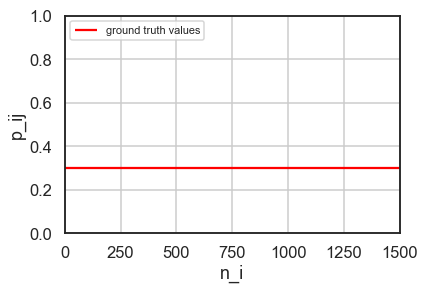

In [3]:
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )
plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)
plt.show()

## 2. Use IPSP to estimate the $p_{ij}$ given the simulated data

In [4]:
# this is the IPSP estimator
def IPSP_est_pij(ni, nij, c_prior_lower, c_prior_upper, mij_prior_lower, mij_prior_upper):
#define function to use sets of priors to update transition probabilityes p_ij (renamed as mij)
#the n_i is the totoal outgoing transitions from state i
#the n_ij is the transtions from i to j.
#the other 4 parameters are defining the set of priors of IPSP
    mij_post_lower=0
    mij_post_upper=0

    if(ni==0):
        return mij_prior_lower, mij_prior_upper
    if(nij/ni) >= mij_prior_lower:
        mij_post_lower=(c_prior_upper*mij_prior_lower+nij)/(c_prior_upper+ni)
        
    if(nij/ni) < mij_prior_lower:
        mij_post_lower=(c_prior_lower*mij_prior_lower+nij)/(c_prior_lower+ni)
        
    if (nij/ni) <= mij_prior_upper:
        mij_post_upper=(c_prior_upper*mij_prior_upper+nij)/(c_prior_upper+ni)
        
    if (nij/ni) > mij_prior_upper:
        mij_post_upper=(c_prior_lower*mij_prior_upper+nij)/(c_prior_lower+ni)

    return mij_post_lower, mij_post_upper

In [5]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=10
n_prior_upper=300
pij_prior_lower=0.2
pij_prior_upper=0.4

current_epoch=1
while current_epoch<len(data):
    #fisrt, statistics on n_i and n_ij
    n_i=len(data[0:current_epoch])
    n_ij=sum(data[0:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1

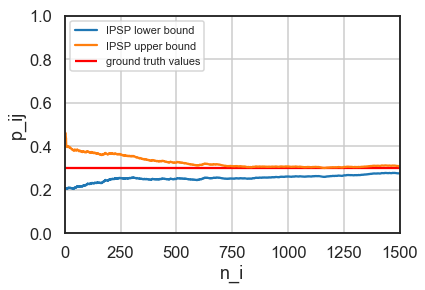

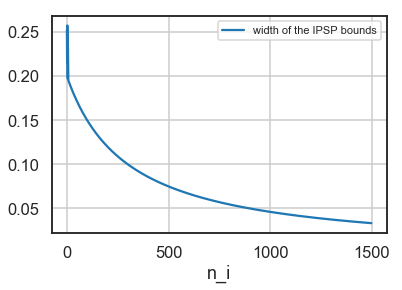

In [6]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(IPSP_est_lower, label='IPSP lower bound',linestyle='-')
plt.plot(IPSP_est_upper, label='IPSP upper bound',linestyle='-')

plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)

plt.show()

plt.plot(np.array(IPSP_est_diff),label='width of the IPSP bounds')
plt.legend(loc='upper right',fontsize=11)
plt.xlabel('n_i')
#plt.ylabel('p_ij')
plt.grid(True)
plt.show()


## 3. The trigger of CPD

In [7]:

the_tp=0# the trigger point
current_epoch=1 #the trigger point only 
while current_epoch<len(data)-1:
    #if current width is bigger than 1.05 * the minimum width seen so far
    #1.05 the threshold factor that can be changed by experts.
    if current_epoch>100 and IPSP_est_diff[current_epoch]-IPSP_est_diff[current_epoch-1]>0:
        the_tp=current_epoch
        break
    current_epoch=current_epoch+1

In [8]:
#now the window of the data is from 0 to the_tp
if the_tp==0:
    print('no CPD analysis is triigred')
else:
    w=the_tp
    print('the tirgier point is at {}'.format(w))
    

no CPD analysis is triigred


## Now let us change the priors of IPSP

In [9]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=5
n_prior_upper=150
pij_prior_lower=0.25
pij_prior_upper=0.35


m_window_size=300 #the size of the moving window

current_epoch=1
while current_epoch<len(data):
    #fisrt, statistics on n_i and n_ij
    if current_epoch<=m_window_size:
        n_i=len(data[0:current_epoch])
        n_ij=sum(data[0:current_epoch])
    else:
        n_i=len(data[current_epoch-m_window_size:current_epoch])
        n_ij=sum(data[current_epoch-m_window_size:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1

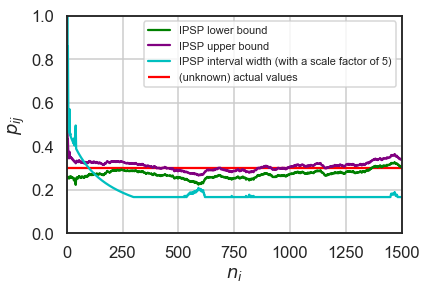

In [10]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='(unknown) actual values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(IPSP_est_lower, label='IPSP lower bound',linestyle='-',color='green')
plt.plot(IPSP_est_upper, label='IPSP upper bound',linestyle='-',color='purple')

plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=12)
plt.xlabel('$n_i$')
plt.ylabel('$p_{ij}$')
plt.grid(True)

plt.plot(np.array(IPSP_est_diff)*5,label='IPSP interval width (with a scale factor of 5)',color='c')
plt.legend(loc='upper right',fontsize=11)
plt.xlabel('$n_i$')
#plt.ylabel('p_ij')
plt.grid(True)
plt.show()


In [11]:
IPSP_est_diff=np.array(IPSP_est_diff)
IPSP_est_diff=np.round(IPSP_est_diff,10)#clean the anoying floating point 

the_tp=0# the trigger point
current_epoch=1 #the trigger point only 
while current_epoch<len(data)-1:
    #if current width is bigger than 1.05 * the minimum width seen so far
    #1.05 the threshold factor that can be changed by experts.
    if current_epoch>100 and IPSP_est_diff[current_epoch]-IPSP_est_diff[current_epoch-1]>0:
        the_tp=current_epoch
        break
    current_epoch=current_epoch+1
#now the window of the data is from 0 to the_tp
if the_tp==0:
    print('no CPD analysis is triigred')
else:
    w=the_tp
    print('the tirgier point is at {}'.format(w))
    


the tirgier point is at 527


## 4. The CPD analysis

Now let us define our likelihood function

In [12]:
def N(x):
    # return the number of transitions before the x point 
    return np.sum(data[0:x])
     
def M(x):
    # return the number of transitions after the x point 
    return np.sum(data[x:w])

def likelihood(x):
    # simply the binomial likelihood, maybe better to use log- to increase the precision..
    #x=int(x)
    a=np.float64(N(x)/x)
    b=np.float64(M(x)/(w-x))# note, here w!=x..
    return (a**(N(x)))*((1-a)**(x-N(x)))*(b**M(x))*((1-b)**(w-x-M(x)))
    

print(likelihood(the_cp-30),likelihood(w-1))

3.504603639910576e-136 4.585718178015157e-136


Now let us do MCMC samplings...

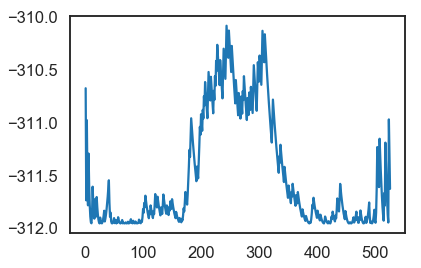

In [13]:

#this code is to visualise the likelihood
def h(b):
    l = []
    for i in b:
        l.append(math.log(likelihood(i)))
    return l
t = np.arange(1, w, 1)
plt.plot(t, h(t))
plt.show()


In [14]:
x_current = round(w/2) #starting point of MCMC
x_posterior=[x_current] 
samples=5000 # number of samples
std=1000 #the std of the proposal dist. which needs to be fine tuned
test=[1]

for i in range(samples):
    # step 1: from a symetrical normal dist., sample a proposed x 
    
    proposal = np.random.normal(x_current, std, 1) 
    
    
    while proposal[0]<=0 or proposal[0]>=w: #the proposal x cannot be out of the data window..
        proposal = np.random.normal(x_current, std, 1)

    proposal=int(proposal[0])

    #step 2: let us decide if we accpet that proposal or not.
    likelihood_current =likelihood(x_current)
    likelihood_proposal =likelihood(proposal)

    # Compute prior probability of current and proposed x        
    prior_current = 1/w #here we assume prior x is unifomly distributed, but you can use others\\
    prior_proposal = 1/w # for sure, then you change here..

    # Nominator of Bayes formula
    p_current = likelihood_current #* prior_current
    p_proposal = likelihood_proposal #* prior_proposal

    p_accept = p_proposal / p_current
    

    accept = np.random.rand() < p_accept
    test.append(accept) # record the number of proposals being accpeted for fine tune.

    # if accpet then change the x_current and put the accpected sample in to posterior

    if accept:
    # Update position
        x_current = proposal
        x_posterior.append(x_current)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0, 0.0012, 'Variance=20298.684977')

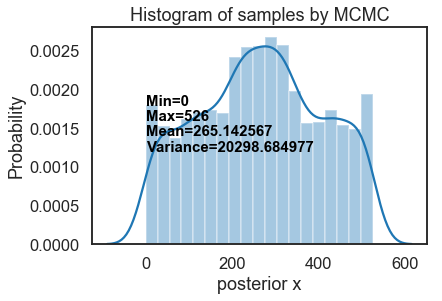

In [15]:
ax = plt.subplot()
sns.distplot(x_posterior, ax=ax, kde=True, hist=True)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior x', ylabel='Probability');

ax.text(min(x_posterior),0.0018,'Min=%d'%min(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.0016,'Max=%d'%max(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.0014,'Mean=%f'%sp.mean(x_posterior),size=15, color='black', weight='semibold')
ax.text(min(x_posterior),0.0012,'Variance=%f'%sp.var(x_posterior),size=15, color='black', weight='semibold')


In [16]:
print(sum(test)/samples)# tune the std in the MCMC, good range is 0.2-0.5
print(sum(test))

0.6902
3451


Text(0.0, 21, 'Variance=0.000827')

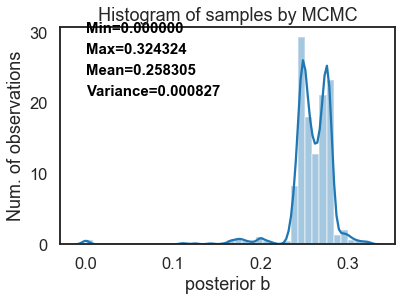

In [17]:
# correspondingly the posterior for b is
def calulate_b_post(x_post):
    b_post = []
    for i in x_post:
        b_post.append((M(i))/(w-i))
    return b_post

b_posterior=calulate_b_post(x_posterior)
ax = plt.subplot()

sns.distplot(b_posterior, ax=ax, kde=True, hist=True, bins=40)
_ = ax.set(title='Histogram of samples by MCMC', xlabel='posterior b', ylabel='Num. of observations');

ax.text(min(b_posterior),30,'Min=%f'%min(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),27,'Max=%f'%max(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),24,'Mean=%f'%sp.mean(b_posterior),size=15, color='black', weight='semibold')
ax.text(min(b_posterior),21,'Variance=%f'%sp.var(b_posterior),size=15, color='black', weight='semibold')

Now do some statistics on the two posterior distributions

In [18]:
print(sp.stats.describe(x_posterior))
print(sp.stats.describe(b_posterior))

DescribeResult(nobs=3451, minmax=(0, 526), mean=265.1425673717763, variance=20304.568654160314, skewness=-0.021232145178247223, kurtosis=-0.943315718485866)
DescribeResult(nobs=3451, minmax=(0.0, 0.32432432432432434), mean=0.25830513048527015, variance=0.0008267942195055728, skewness=-4.517565780112504, kurtosis=34.672505629161236)
